This notebook is for the development of the Sentiment Analysis script that was used in the Trading Systems Development IQP. The indicator attempts to measure the sentiment of news headlines, which will be used to predict upcomming movements in the markets. 

The headlines are scraped using Selenium from the Investing.com website. The headlines are then preprocessed and their sentiment analyzed using the lexicon approach described by Loughran and McDonald [1]. The lexicon approach entails the use of two lists of words, one negative and one positive, counting the number of each type of word as well as the frequency of each individual word. This method yields a score for each headline, which is then aggregated on a daily basis to determine the score of the day.

[1] "When is a liability not a liability? Textual Analysis, Dictionaries, and 10-Ks" https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1331573 


The sentiment score is calculated using the following formula:

$$
f(x) = \left\{
        \begin{array}{ll}
            \frac{(1+log(tf_{i,j}))}{(1+log(a))}*log(\frac{N}{df_{i,j}}) & tf_{i,j} \geq 1\\
            0 & otherwise
        \end{array}
    \right.
$$

Where the following variables are used:

$$
\text{N, the total number of headlines in the sample.}
\\
\text{a, the average word count in the sample.}
\\
\text{ $tf_{i,j}$, the raw count of the $i^{th}$ word in the $j^{th}$ document.}
\\
\text{$df_i$, the number of headlines containing at least one occurrence of the $i^{th}$ word.}
$$


The following lines preload the data, import necessary libraries and create user defined functions.

In [218]:
import os
import pandas as pd
#import collocation_analysis as ca
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
#from investing_scrape import scrape_headlines
import numpy as np
import re
from decimal import Decimal
import json
import time
import unicodedata
from pandas import DataFrame
from selenium import webdriver
from bs4 import BeautifulSoup
import datetime

#region FUNCTION DEFINITIONS
def clean_Text(text):
    """
    removes punctuation, stopwords and returns lowercase text in a list of single words
    """    
    print(text)
    # If the string happens to be NaN, the regexp module will throw an error. By checking for the length of the 
    # string I can catch whether it is a string or not for a TypeError will be thrown if it is not a string. 
    try:
        t = len(text)
        #Tokenize the text
        tokenizer = RegexpTokenizer(r'\w+')
        text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
        text = text.lower()
        text = tokenizer.tokenize(text)

        #Clean the text
        clean = [word for word in text if word not in stopwords.words('english')]

        return clean
    
    except TypeError:
        return "null"

# Load the list of positive words
def loadPositive():
    #filepath = os.path.dirname(os.path.abspath(__file__))
    #C:\\Users\\afn\\Desktop\\Intern_Projects\\
    #C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\
    with open('C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\LMC_Positive.csv', 'r') as f:
        pos_lines = f.readlines()
        pos_lex_lists = [word.strip() for word in pos_lines]
        return pos_lex_lists


# Load the list of negative words
def loadNegative():
    #filepath = os.path.dirname(os.path.abspath(__file__))
    #C:\\Users\\afn\\Desktop\\Intern_Projects\\
    #C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\
    with open('C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\LMC_Negative.csv', 'r') as f:
        neg_lines = f.readlines()
        neg_lex_lists = [word.strip() for word in neg_lines]
        return neg_lex_lists


def countNegative(sentence, neg_lex_list, total_headline_count, doc_average_word_count):
    # Sentence is a sentence broken up into a list of words
    # Add a row to the df_frequency dataframe that represents the weight assigned to that word
    # Use the Loughran & McDonald formula to create the weight:
    # Wij = ((1+log(tfij))/(1+log(a)))*log(N/dfi)
    # Where N represents the total number of headlines in the sample
    # dfi the number of headlines containing at least one occurrence of the ith word
    # tfij the raw count of the ith word in the jth document
    # a the average word count in the document
    N = total_headline_count
    headline_score = 0
    a = doc_average_word_count.item()
    for word in sentence:
        if word.upper() in neg_lex_list:
            # Find the index of the word then obtain the corresponding frequency and dfi
            wIndex = list(np.where(df_frequency["word"] == word.lower())[0])[0]
            dfi = df_frequency["dfi"][wIndex]
            # Determine the frequency of this word in this particular headline
            local_freq = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), ' '.join(sentence)))
            # Calculate the weight assigned to this word
            if local_freq == 0 or a == 0 or N/dfi == 0:
                print('*******************************')
                print(local_freq)
                print('*******************************')
                
            weight = ((1+np.log(local_freq))/(1+np.log(a)))*np.log(N/dfi)
            # Add this word score to the headline's score
            if weight != 0:
                headline_score += weight.item()
            else:
                headlines_score += 1

    return headline_score


def countPositive(sentence, pos_lex_list, total_headline_count, doc_average_word_count):
    # Sentence is a sentence broken up into a list of words
    # Add a row to the df_frequency dataframe that represents the weight assigned to that word
    # Use the Loughran & McDonald formula to create the weight:
    # Wij = ((1+log(tfij))/(1+log(a)))*log(N/dfi)
    # Where N represents the total number of headlines in the sample
    # dfi the number of headlines containing at least one occurrence of the ith word
    # tfij the raw count of the ith word in the jth document
    # a the average word count in the document
    N = total_headline_count
    headline_score = 0
    a = doc_average_word_count.item()
    for word in sentence:
        if word.upper() in pos_lex_list:
            # Find the index of the word then obtain the corresponding frequency and dfi
            wIndex = list(np.where(df_frequency["word"] == word.lower())[0])[0]
            dfi = df_frequency["dfi"][wIndex]
            # Determine the frequency of this word in this particular headline
            local_freq = sum(1 for _ in re.finditer(r'\b%s\b' % re.escape(word), ' '.join(sentence)))
            # Calculate the weight assigned to this word
            if local_freq == 0 or a == 0 or N/dfi == 0:
                print('*******************************')
                print(local_freq)
                print('*******************************')
                
            weight = ((1+np.log(local_freq))/(1+np.log(a)))*np.log(N/dfi)
            # Add this word score to the headline's score
            if weight != 0:
                headline_score += weight.item()
            else:
                headlines_score += 1

    return headline_score


def calculateSentiment(clean_headline, positive_list, negative_list, awc):
    # print("CALCULATING SENTIMENT")
    lexicon_negative = countNegative(clean_headline, negative_list, len(df_headlines), awc)
    lexicon_positive = countPositive(clean_headline, positive_list, len(df_headlines), awc)
    return lexicon_positive-lexicon_negative

# Using webdriver to launch the website and allow the javascript to load. Once the JS loads,
# it is possible to extract the source code -> innerHTML
# BeautifulSoup processes the innerHTML, which is then parsed for the desired sections.
# Title, date and url are all stored in a dictionary that has the title as the key.
# The dictionary is stored in a json file for further usage.
def scrape_headlines(starting_page, ending_page, section):
    browser = webdriver.Chrome()
    url_upto_item = "https://www.investing.com/currencies/" + section + '/'
    page_number = starting_page

    # Create a dictionary to store these values. Each title is the key to an entry.
    news = {}
    article_total = 0

    # try:
    #     news[article_total]["source"] = element.span.get_text()[3:]
    # except AttributeError:

    # Loop through all the pages
    while page_number <= ending_page:

        # Join parts of url
        url = url_upto_item + str(page_number)
        # Navigate browser to url
        browser.get(url)

        # Wait 10 seconds for the js to finish loading the webpage
        time.sleep(2)
        # Get innerHTML from webpage
        inner_html = browser.execute_script("return document.body.innerHTML")
        # Parse the innerHTML
        soup = BeautifulSoup(inner_html, 'html.parser')

        # Find all the classes that contain the desired information.
        # Title, url and date are all contained within the 'fxs_floatingMedia..' class in div objects.
        items = soup.find_all("article", class_="articleItem")

        article_counter = 1
        # Clean the gathered text before putting it in the dictionary
        for element in items:
            # Last two articles are not real articles rather some extra stuff on the webpage
            if article_counter < len(items)-2:
                news[article_total] = {}
                news[article_total]["title"] = element.div.a["title"]
                print(element.div.a["title"])
                news[article_total]["date"] = element.findAll("span", {"class": "date"})[0].get_text()[3:]

                # The href standards changed at some point. They are stored in two ways. Here I account for that difference
                if "https://invst.ly" in element.div.a["href"]:
                    news[article_total]["url"] = element.div.a["href"]
                else:
                    news[article_total]["url"] = "https://investing.com" + element.div.a["href"]

                try:
                    news[article_total]["source"] = element.span.span.get_text()[3:]
                except AttributeError:
                    news[article_total]["source"] = element.span.get_text()[3:]

            article_counter += 1
            article_total += 1

        # Increment page number by 1 to navigate to the next page
        page_number += 1

    # ----------------------- DATAFRAME -----------------------

    # create the dataframe from the dictionary
    df = pd.DataFrame.from_dict(news)

    # transpose the columns/rows
    df = df.T

    # Sort by date
    # df = df.sort_values(by=['date'])

    # ----------------------- SAVING -----------------------
    filename = 'headlines_InvestingCom_' + str(starting_page) + '_to_' + str(ending_page) + '.csv'
    # Save the dataframe to a csv file
    df.to_csv(filename, encoding='utf-8')

    print("***********************")
    print("Headline Scraping Done.")
    print("***********************")

    browser.close()

    return df

def wordFrequency(df, content_column):
    # Create a dictionary where to store the words and counts
    frequency = {}

    # Iterate through each row and count the frequency of words
    for index, row in df.iterrows():
        # First clean the text
        text_string = clean_Text(row[content_column])

        # Count word frequency
        for word in text_string:
            if word in frequency:
                frequency[word] += 1
            else:
                frequency[word] = 1

        print(frequency)
    # Create the list with the counts
    frequency_list = frequency.keys()

    # Print words and counts
    for words in frequency_list:
        print(words, frequency[words])

    word_df = pd.DataFrame(list(frequency.items()))
    word_df = word_df.T

    # Save the frequency dictionary to a csv file for further analysis
    with open('word_frequency.csv', 'w') as csv_file:
        word_df.to_csv(csv_file, header=False)
    csv_file.close()

    return word_df

# Using webdriver to launch the website and allow the javascript to load. Once the JS loads,
# it is possible to extract the source code -> innerHTML
# BeautifulSoup processes the innerHTML, which is then parsed for the desired sections.
# Title, date and url are all stored in a dictionary that has the title as the key.
# The dictionary is stored in a json file for further usage.
def scrape_headlines(starting_page, ending_page, section):
    browser = webdriver.Chrome()
    url_upto_item = "https://www.investing.com/currencies/" + section + '/'
    page_number = starting_page

    # Create a dictionary to store these values. Each title is the key to an entry.
    news = {}
    article_total = 0

    # try:
    #     news[article_total]["source"] = element.span.get_text()[3:]
    # except AttributeError:

    # Loop through all the pages
    while page_number <= ending_page:

        # Join parts of url
        url = url_upto_item + str(page_number)
        # Navigate browser to url
        browser.get(url)

        # Wait 10 seconds for the js to finish loading the webpage
        time.sleep(2)
        # Get innerHTML from webpage
        inner_html = browser.execute_script("return document.body.innerHTML")
        # Parse the innerHTML
        soup = BeautifulSoup(inner_html, 'html.parser')

        # Find all the classes that contain the desired information.
        # Title, url and date are all contained within the 'fxs_floatingMedia..' class in div objects.
        items = soup.find_all("article", class_="articleItem")

        article_counter = 1
        # Clean the gathered text before putting it in the dictionary
        for element in items:
            # Last two articles are not real articles rather some extra stuff on the webpage
            if article_counter < len(items)-2:
                news[article_total] = {}
                news[article_total]["title"] = element.div.a["title"]
                print(element.div.a["title"])
                news[article_total]["date"] = element.findAll("span", {"class": "date"})[0].get_text()[3:]

                # The href standards changed at some point. They are stored in two ways. Here I account for that difference
                if "https://invst.ly" in element.div.a["href"]:
                    news[article_total]["url"] = element.div.a["href"]
                else:
                    news[article_total]["url"] = "https://investing.com" + element.div.a["href"]

                try:
                    news[article_total]["source"] = element.span.span.get_text()[3:]
                except AttributeError:
                    news[article_total]["source"] = element.span.get_text()[3:]

            article_counter += 1
            article_total += 1

        # Increment page number by 1 to navigate to the next page
        page_number += 1

    # ----------------------- DATAFRAME -----------------------

    # create the dataframe from the dictionary
    df = pd.DataFrame.from_dict(news)

    # transpose the columns/rows
    df = df.T

    # Sort by date
    # df = df.sort_values(by=['date'])

    # ----------------------- SAVING -----------------------
    filename = 'headlines_InvestingCom_' + str(starting_page) + '_to_' + str(ending_page) + '.csv'
    # Save the dataframe to a csv file
    df.to_csv(filename, encoding='utf-8')

    print("***********************")
    print("Headline Scraping Done.")
    print("***********************")

    browser.close()

    return df


# This function iterates through the dataframe and removes advert entries as well as corrects dates that are improperly formatted
# as a number of hours ago rather than a date.
def clean_dataframe():
    global df_headlines
    
    now = datetime.datetime.now()
    df_headlines_clean = pd.DataFrame()
    index_remove = []
    
    df_headlines_cp = df_headlines.copy()
    for index, row in df_headlines_cp.iterrows():
        # Replace "X hours ago" entries for today's date
        if 'hour' in row['date']:
            df_headlines.iloc[index]['date'] = now.strftime('%b %d, %Y')
        
        if 'https://investing.com/education/' in row['url']:
            df_headlines = df_headlines.drop([index])        
    
    return
        
        


Scrape the Investing.com website and obtain a list of headlines.

In [213]:
df_headlines = scrape_headlines(1, 20, 'usd-chf-news')
clean_dataframe()
df_headlines

US Dollar Price Action Setups: Q3 Preview
USD/CHF Technical Analysis: Greenback bulls stopped before parity after two-day advance
Forex - Dollar Flat as U.S. Economy Slows in First Quarter 
USD/CHF finds resistance ahead of parity, turns negative near 0.9960
Forex - Dollar Gets Lift From Easing Trade War Fears
USD/CHF Technical Analysis: Greenback gaining ground against Swissy for the second consecutive day
USD/CHF advances to mid-0.99s on higher risk appetite
US Dollar Extends Support Bounce as EUR/USD, GBP/USD Turn Lower
The CAD is the strongest. The NZD is the weakest as NA traders enter for the day.
USD/CHF scope for a test of 0.9789/33 – Commerzbank
Know Smallcap Multibaggers for July-Sep ‘18 Quarter
US Dollar Price Action Setups as End of Q2 Nears
USD/CHF pushes above 0.99 on improved sentiment and stronger greenback
Forex - Dollar Edges Higher as Appetite for Safe-Haven Currencies Fade
US Dollar Digs into Fibonacci Support as EUR/USD Holds Key Resistance
Technical Update For EUR

Forex- Dollar Lower as Government Shutdown Weighs
Forex - Dollar Remains Broadly Lower on U.S. Politics
Forex - Dollar Slips Lower after U.S. Government Shutdown
CFTC: Crude Oil Net Longs at All-Time High; Speculators Less Bullish on Euro
Forex - Dollar Trims Losses But Remains Near 3-Year Trough
Forex - Dollar Returns Near 3-Year Lows Vs. Other Majors
Forex - Dollar Slips Lower on Fears of U.S. Government Shutdown
Forex - Dollar Retreats as Fears of Government Shutdown Grow
Forex - Dollar Remains Moderately Lower Vs. Rivals, U.S. Data Ahead
Forex - Dollar Holds Onto Modest Gains Just Off 3-Year Trough
Know Smallcap Multibaggers for July-Sep ‘18 Quarter
Forex - Dollar Continues to Mildly Recover But Gains Seen Limited
Forex - Dollar Index Continues to Drop, Hits Fresh 3-Year Trough
CFTC: Crude Oil, Euro Net Longs at All-Time Highs; Speculators Turn Bullish on AUD
Forex- Dollar Falls to Four-Month Low as Euro, Sterling Surge
Forex - Dollar Remains Near 4-Month Trough After U.S. Data
For

,date,source,title,url
0,"Jun 28, 2018",Dailyfx,US Dollar Price Action Setups: Q3 Preview,https://invst.ly/7vh7y
1,"Jun 28, 2018",FXStreet,USD/CHF Technical Analysis: Greenback bulls st...,https://invst.ly/7vg3j
2,"Jun 28, 2018",Investing.com,Forex - Dollar Flat as U.S. Economy Slows in F...,https://investing.com/news/forex-news/forex--d...
3,"Jun 28, 2018",FXStreet,"USD/CHF finds resistance ahead of parity, turn...",https://invst.ly/7vcb4
4,"Jun 27, 2018",Investing.com,Forex - Dollar Gets Lift From Easing Trade War...,https://investing.com/news/forex-news/forex--d...
5,"Jun 27, 2018",FXStreet,USD/CHF Technical Analysis: Greenback gaining ...,https://invst.ly/7uyof
6,"Jun 27, 2018",FXStreet,USD/CHF advances to mid-0.99s on higher risk a...,https://invst.ly/7uxql
7,"Jun 27, 2018",Dailyfx,"US Dollar Extends Support Bounce as EUR/USD, G...",https://invst.ly/7uxun
8,"Jun 27, 2018",Forexlive,The CAD is the strongest. The NZD is the weake...,https://invst.ly/7uwhy
9,"Jun 27, 2018",FXStreet,USD/CHF scope for a test of 0.9789/33 – Commer...,https://invst.ly/7us4i


Next, create/import the dataframes containing the data to analyze. In this case the headlines have been downloaded previously, so they are imported from a csv file. The date column is converted to a datetime object for easy manipulation.


In [214]:
#df_prices = pd.read_csv("C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\USD_CHF_Sent_Prices.csv")
#df_aaii = pd.read_csv("C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\aaii_sentiment.csv")
df_prices = pd.read_csv("C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\USD_CHF_Sent_Prices.csv")
df_aaii = pd.read_csv("C:\\Users\\Alan Fernandez\\IQPython\\fxnews\\fxnews\\csv_files\\aaii_sentiment.csv")

df_prices['date'] = pd.to_datetime(df_prices['date'])
df_aaii['date'] = pd.to_datetime(df_aaii['date'])
print(df_headlines)

             date         source  \
0    Jun 28, 2018        Dailyfx   
1    Jun 28, 2018       FXStreet   
2    Jun 28, 2018  Investing.com   
3    Jun 28, 2018       FXStreet   
4    Jun 27, 2018  Investing.com   
5    Jun 27, 2018       FXStreet   
6    Jun 27, 2018       FXStreet   
7    Jun 27, 2018        Dailyfx   
8    Jun 27, 2018      Forexlive   
9    Jun 27, 2018       FXStreet   
14   Jun 26, 2018        Dailyfx   
15   Jun 26, 2018       FXStreet   
16   Jun 26, 2018  Investing.com   
17   Jun 26, 2018        Dailyfx   
18   Jun 26, 2018       FXEmpire   
19   Jun 25, 2018       FXStreet   
20   Jun 25, 2018        Dailyfx   
21   Jun 25, 2018  Investing.com   
22   Jun 25, 2018  Investing.com   
23   Jun 25, 2018       FXStreet   
28   Jun 25, 2018       FXStreet   
29   Jun 25, 2018       FXStreet   
30   Jun 22, 2018       FXStreet   
31   Jun 22, 2018       FXStreet   
32   Jun 22, 2018       FXStreet   
33   Jun 22, 2018       FXStreet   
34   Jun 21, 2018       FXSt

Create lists to store calculations. These lists will eventually become the columns in the final dataframe. The positive and negative lexicon are loaded as well.

In [215]:
pos_lex_list = loadPositive()
neg_lex_list = loadNegative()
# Indicator lists
aaii_sent_list = []
lexicon_sent_list = []
market_sent_list = []
# A list of ngrams that have more weight in the analysis.
# ngram_list = []
ngram_match_list = []
# Where the final aggregate sentiment is stored
final_sent_list = []
final_sent_list_word = []
new_range  = [i * i for i in range(5) if i % 2 == 0]

Determine word frequency in the entire database of headlines. Frequency will be used as a weight to balance 
terms with different levels of popularity.

In [216]:
df_frequency = wordFrequency(df_headlines, "title")

N = len(df_headlines)
average_word_count = df_frequency[1:2].sum(axis=1)/N
word_occurrence = [0 for x in range(df_frequency.count(axis='columns')[1])]
headlines_list = df_headlines['title'].tolist()
word_list = df_frequency[0:1].values.tolist()[0]

for word_index, word in enumerate(word_list):
    for headline in headlines_list:
        #print(word)
        hd = RegexpTokenizer(r'\w+').tokenize(headline)
        hd_upper = [word.upper() for word in hd]
        #print(hd_upper)
        if word.upper() in hd_upper:
            #print(word.upper())
            word_occurrence[word_index] += 1

# Add the number of occurrences to the data frame
df_frequency = df_frequency.append([word_occurrence], ignore_index=True)
df_frequency = df_frequency.T
df_frequency.columns = ["word", "frequency", "dfi"]

# Calculate the weight
word_weight = [0 for x in range(df_frequency.count(axis='columns')[1])]

print(df_frequency)

US Dollar Price Action Setups: Q3 Preview
{'us': 1, 'dollar': 1, 'price': 1, 'action': 1, 'setups': 1, 'q3': 1, 'preview': 1}
USD/CHF Technical Analysis: Greenback bulls stopped before parity after two-day advance
{'us': 1, 'dollar': 1, 'price': 1, 'action': 1, 'setups': 1, 'q3': 1, 'preview': 1, 'usd': 1, 'chf': 1, 'technical': 1, 'analysis': 1, 'greenback': 1, 'bulls': 1, 'stopped': 1, 'parity': 1, 'two': 1, 'day': 1, 'advance': 1}
Forex - Dollar Flat as U.S. Economy Slows in First Quarter 
{'us': 1, 'dollar': 2, 'price': 1, 'action': 1, 'setups': 1, 'q3': 1, 'preview': 1, 'usd': 1, 'chf': 1, 'technical': 1, 'analysis': 1, 'greenback': 1, 'bulls': 1, 'stopped': 1, 'parity': 1, 'two': 1, 'day': 1, 'advance': 1, 'forex': 1, 'flat': 1, 'u': 1, 'economy': 1, 'slows': 1, 'first': 1, 'quarter': 1}
USD/CHF finds resistance ahead of parity, turns negative near 0.9960
{'us': 1, 'dollar': 2, 'price': 1, 'action': 1, 'setups': 1, 'q3': 1, 'preview': 1, 'usd': 2, 'chf': 2, 'technical': 1, 'analy

{'us': 8, 'dollar': 15, 'price': 3, 'action': 3, 'setups': 4, 'q3': 1, 'preview': 1, 'usd': 33, 'chf': 22, 'technical': 6, 'analysis': 4, 'greenback': 3, 'bulls': 1, 'stopped': 1, 'parity': 2, 'two': 1, 'day': 5, 'advance': 2, 'forex': 7, 'flat': 1, 'u': 3, 'economy': 1, 'slows': 1, 'first': 1, 'quarter': 1, 'finds': 1, 'resistance': 2, 'ahead': 4, 'turns': 1, 'negative': 1, 'near': 1, '0': 10, '9960': 1, 'gets': 1, 'lift': 1, 'easing': 1, 'trade': 4, 'war': 3, 'fears': 3, 'gaining': 1, 'ground': 1, 'swissy': 1, 'second': 1, 'consecutive': 1, 'advances': 1, 'mid': 2, '99s': 1, 'higher': 3, 'risk': 2, 'appetite': 2, 'extends': 3, 'support': 3, 'bounce': 1, 'eur': 4, 'gbp': 3, 'turn': 1, 'lower': 1, 'cad': 2, 'strongest': 1, 'nzd': 3, 'weakest': 1, 'na': 1, 'traders': 2, 'enter': 1, 'scope': 1, 'test': 1, '9789': 1, '33': 1, 'commerzbank': 4, 'end': 1, 'q2': 1, 'nears': 1, 'pushes': 1, '99': 3, 'improved': 1, 'sentiment': 3, 'stronger': 1, 'edges': 2, 'safe': 5, 'currencies': 2, 'fade': 

{'us': 8, 'dollar': 44, 'price': 3, 'action': 3, 'setups': 4, 'q3': 1, 'preview': 1, 'usd': 33, 'chf': 22, 'technical': 6, 'analysis': 4, 'greenback': 3, 'bulls': 1, 'stopped': 1, 'parity': 2, 'two': 1, 'day': 5, 'advance': 2, 'forex': 41, 'flat': 1, 'u': 17, 'economy': 1, 'slows': 1, 'first': 1, 'quarter': 1, 'finds': 1, 'resistance': 2, 'ahead': 5, 'turns': 1, 'negative': 1, 'near': 4, '0': 10, '9960': 1, 'gets': 1, 'lift': 1, 'easing': 1, 'trade': 8, 'war': 5, 'fears': 5, 'gaining': 1, 'ground': 1, 'swissy': 1, 'second': 1, 'consecutive': 1, 'advances': 1, 'mid': 2, '99s': 1, 'higher': 5, 'risk': 2, 'appetite': 2, 'extends': 4, 'support': 3, 'bounce': 1, 'eur': 4, 'gbp': 3, 'turn': 1, 'lower': 4, 'cad': 2, 'strongest': 1, 'nzd': 3, 'weakest': 1, 'na': 1, 'traders': 5, 'enter': 1, 'scope': 1, 'test': 1, '9789': 1, '33': 1, 'commerzbank': 4, 'end': 1, 'q2': 1, 'nears': 1, 'pushes': 3, '99': 3, 'improved': 1, 'sentiment': 3, 'stronger': 1, 'edges': 3, 'safe': 6, 'currencies': 3, 'fade'

{'us': 8, 'dollar': 78, 'price': 3, 'action': 3, 'setups': 4, 'q3': 1, 'preview': 1, 'usd': 33, 'chf': 22, 'technical': 6, 'analysis': 4, 'greenback': 3, 'bulls': 1, 'stopped': 1, 'parity': 2, 'two': 1, 'day': 5, 'advance': 2, 'forex': 75, 'flat': 1, 'u': 26, 'economy': 1, 'slows': 1, 'first': 1, 'quarter': 1, 'finds': 1, 'resistance': 2, 'ahead': 8, 'turns': 6, 'negative': 1, 'near': 6, '0': 10, '9960': 1, 'gets': 1, 'lift': 1, 'easing': 1, 'trade': 12, 'war': 5, 'fears': 5, 'gaining': 1, 'ground': 1, 'swissy': 1, 'second': 1, 'consecutive': 1, 'advances': 1, 'mid': 2, '99s': 1, 'higher': 11, 'risk': 2, 'appetite': 2, 'extends': 5, 'support': 3, 'bounce': 1, 'eur': 4, 'gbp': 3, 'turn': 1, 'lower': 12, 'cad': 2, 'strongest': 1, 'nzd': 3, 'weakest': 1, 'na': 1, 'traders': 7, 'enter': 1, 'scope': 1, 'test': 1, '9789': 1, '33': 1, 'commerzbank': 4, 'end': 1, 'q2': 1, 'nears': 1, 'pushes': 4, '99': 3, 'improved': 1, 'sentiment': 3, 'stronger': 1, 'edges': 4, 'safe': 6, 'currencies': 5, 'fa

{'us': 8, 'dollar': 112, 'price': 3, 'action': 3, 'setups': 4, 'q3': 1, 'preview': 1, 'usd': 33, 'chf': 22, 'technical': 6, 'analysis': 4, 'greenback': 3, 'bulls': 1, 'stopped': 1, 'parity': 2, 'two': 1, 'day': 5, 'advance': 2, 'forex': 107, 'flat': 1, 'u': 35, 'economy': 1, 'slows': 1, 'first': 1, 'quarter': 1, 'finds': 1, 'resistance': 2, 'ahead': 11, 'turns': 6, 'negative': 1, 'near': 10, '0': 10, '9960': 1, 'gets': 1, 'lift': 1, 'easing': 1, 'trade': 13, 'war': 5, 'fears': 7, 'gaining': 1, 'ground': 1, 'swissy': 1, 'second': 1, 'consecutive': 1, 'advances': 1, 'mid': 2, '99s': 1, 'higher': 11, 'risk': 2, 'appetite': 2, 'extends': 6, 'support': 3, 'bounce': 1, 'eur': 4, 'gbp': 3, 'turn': 2, 'lower': 19, 'cad': 2, 'strongest': 1, 'nzd': 3, 'weakest': 1, 'na': 1, 'traders': 7, 'enter': 1, 'scope': 1, 'test': 1, '9789': 1, '33': 1, 'commerzbank': 4, 'end': 1, 'q2': 1, 'nears': 1, 'pushes': 4, '99': 3, 'improved': 1, 'sentiment': 3, 'stronger': 1, 'edges': 4, 'safe': 6, 'currencies': 5,

{'us': 8, 'dollar': 146, 'price': 3, 'action': 3, 'setups': 4, 'q3': 1, 'preview': 1, 'usd': 33, 'chf': 22, 'technical': 6, 'analysis': 4, 'greenback': 3, 'bulls': 1, 'stopped': 1, 'parity': 2, 'two': 1, 'day': 6, 'advance': 2, 'forex': 140, 'flat': 1, 'u': 45, 'economy': 1, 'slows': 1, 'first': 1, 'quarter': 1, 'finds': 1, 'resistance': 2, 'ahead': 11, 'turns': 6, 'negative': 2, 'near': 11, '0': 11, '9960': 1, 'gets': 1, 'lift': 1, 'easing': 1, 'trade': 23, 'war': 5, 'fears': 7, 'gaining': 1, 'ground': 1, 'swissy': 1, 'second': 1, 'consecutive': 1, 'advances': 1, 'mid': 2, '99s': 1, 'higher': 15, 'risk': 2, 'appetite': 2, 'extends': 7, 'support': 4, 'bounce': 1, 'eur': 4, 'gbp': 3, 'turn': 3, 'lower': 26, 'cad': 2, 'strongest': 1, 'nzd': 3, 'weakest': 1, 'na': 1, 'traders': 7, 'enter': 1, 'scope': 1, 'test': 1, '9789': 1, '33': 1, 'commerzbank': 4, 'end': 1, 'q2': 1, 'nears': 1, 'pushes': 5, '99': 3, 'improved': 1, 'sentiment': 3, 'stronger': 1, 'edges': 7, 'safe': 6, 'currencies': 5,

support 4
bounce 1
eur 4
gbp 4
turn 3
lower 27
cad 2
strongest 1
nzd 3
weakest 1
na 1
traders 7
enter 1
scope 1
test 1
9789 1
33 1
commerzbank 4
end 1
q2 1
nears 1
pushes 5
99 3
improved 1
sentiment 3
stronger 1
edges 7
safe 7
currencies 5
fade 1
digs 1
fibonacci 1
holds 21
key 3
update 1
jpy 1
26 1
06 2
2018 4
hits 7
fresh 10
weekly 8
lows 16
losses 7
fx 1
week 21
june 1
25 1
gold 4
prices 3
struggle 2
despite 6
rising 1
demand 3
skids 1
heat 1
today 1
downfall 1
confirms 1
bearish 2
double 2
top 4
h4 2
1 17
2 9
around 2
9870 1
looks 2
vulnerable 1
retreats 2
trump 1
comments 2
weigh 2
market 2
remains 28
highly 1
valued 1
danske 1
bank 2
formation 1
positive 1
9875 1
72 1
plummets 1
index 20
continue 1
weaken 1
mood 1
persists 1
snb 3
leaves 2
rate 6
hold 3
swiss 6
national 1
keeps 1
75 2
widely 1
expected 1
move 1
trying 1
glimpse 1
000 1
call 1
thursday 1
subdued 3
fights 1
back 8
housing 4
data 26
fall 5
short 1
trims 5
early 1
gains 19
9900s 1
havens 2
weakens 1
improves 1
consol

Analyze the sentiment of the headlines.

In [219]:
lexicon_sent_list = []
for index, row in df_headlines.iterrows():
    # First clean and tokenize the text
    # print("INDEX: " + str(index))
    word_list = clean_Text(row["title"])
    # If one of the lists does not contain a certain date, an error will be thrown upon trying to access that date
    # Catch that error and skip that date
    try:
        # row_index = df_prices.loc[df_prices['date'] == df_headlines.iloc[index]['date']]
        # LEXICON SENTIMENT OF THE TEXT
        # Set the sentiment to 1, -1 or 0 (Pos, Neg, Neutral)
        # Set a flag to identify which list threw the error and to react accordingly
        flag = 0
        s = calculateSentiment(word_list, pos_lex_list, neg_lex_list, average_word_count)

        lexicon_sent_list += [s]

        #
        # # NGRAM SENTIMENT OF THE TEXT
        # ngram_sent_temp = checkNgram(word_list, pos_ngram_list, neg_ngram_list)
        # if (ngram_sent_temp[0] > ngram_sent_temp[1]):
        #     ngram_sent_list += [-1]
        # elif (ngram_sent_temp[1] > ngram_sent_temp[0]):
        #     ngram_sent_list += [1]
        # else:
        #     ngram_sent_list += [0]
        # # Store the matching ngrams
        # ngram_match_list += [ngram_sent_temp[2]]
        #
        # # MARKET SENTIMENT OF THE TEXT
        # flag = 1
        # market_sent_list += [1 if row_index['close'].item() - row_index['open'].item() > 0 else -1]


    except ValueError:
        # If the lexicon sentiment throws an error
        if flag == 0:
            market_sent_list += [0]
            lexicon_sent_list += [0]
        # If the market sentiment throws an error
        else:
            market_sent_list += [0]
            lexicon_sent_list[index] = 0
        # skipcount += 1
        # print("Skip: " + str(skipcount))
        continue
#endregion

US Dollar Price Action Setups: Q3 Preview
USD/CHF Technical Analysis: Greenback bulls stopped before parity after two-day advance
Forex - Dollar Flat as U.S. Economy Slows in First Quarter 
USD/CHF finds resistance ahead of parity, turns negative near 0.9960
Forex - Dollar Gets Lift From Easing Trade War Fears
USD/CHF Technical Analysis: Greenback gaining ground against Swissy for the second consecutive day
USD/CHF advances to mid-0.99s on higher risk appetite
US Dollar Extends Support Bounce as EUR/USD, GBP/USD Turn Lower
The CAD is the strongest. The NZD is the weakest as NA traders enter for the day.
USD/CHF scope for a test of 0.9789/33 – Commerzbank
US Dollar Price Action Setups as End of Q2 Nears
USD/CHF pushes above 0.99 on improved sentiment and stronger greenback
Forex - Dollar Edges Higher as Appetite for Safe-Haven Currencies Fade
US Dollar Digs into Fibonacci Support as EUR/USD Holds Key Resistance
Technical Update For EUR/USD, USD/JPY, NZD/USD & USD/CHF: 26.06.2018
USD/CHF

Forex - Dollar Holds Steady After Mostly Downbeat U.S. Data
Forex - Dollar Little Changed in Quiet Pre-Holiday Trade
Forex - Dollar Holds Steady Near 2-1/2 Week Lows Vs. Rivals
Forex- Dollar Falls Despite Tax Bill Reform
Forex - Dollar Almost Unchanged Despite U.S. Tax Reform Progress
Forex - Dollar Holds Steady Vs. Rivals in Subdued Trade
Forex - Dollar Little Changed as U.S. Tax Reform Optimism Wanes
Forex - Dollar Remains Moderately Lower Despite Upbeat U.S. Data
Forex - Dollar Index Little Changed in Quiet Trade
Forex - Dollar Holds Steady With U.S. Tax Reform, Data in Focus
Forex - Dollar Extends Losses in Subdued Pre-Holiday Trade
Forex - Dollar Falls to 1-1/2 Week Lows in Cautious Trade
Forex - Dollar Slips Lower but U.S. Tax Hopes Support
Forex - Dollar Bounces Higher but Upside Seen Limited
Forex - Dollar Still on the Downside After Weak U.S. Data
Forex - Dollar Remains Moderately Lower in Cautious Trade
Forex - Dollar Slips Lower Amid Fresh U.S. Tax Reform Woes
Forex - Dollar

Now combine the sentiment results with the corresponding headlines. Since each element in the sentiment list is the sentiment of the corresponding headline (index wise), this should be as simple as appending both lists to a DF. This new DF should be a copy of df_headlines with the sentiment column appended. 

In [220]:
df_headlines_sent = df_headlines.copy()
df_headlines_sent['sent'] = lexicon_sent_list

Now, with the DF ready with both headlines and sentiment, aggregate those sentiment scores into a final DF that includes one entry per date with the aggreate sentiment for that day. This will be the final output of the sentiment analyzer and will be imported into TradeStation. The date column should be date objects and the sentiment column should be titled 'Close' to match the format required by TS for third party data.

In [221]:
from datetime import datetime
from dateutil.parser import parse

sentiment_dict = {}
for index, row in df_headlines_sent.iterrows():
    if index > 5:
        # If the date already exists, then just add to the sentiment score.
        if row['date'] not in sentiment_dict:
            sentiment_dict[row['date']] = row['sent']
        # If the date doesn't exist, then append it to the end of the dictionary.
        else:
            sentiment_dict[row['date']] += row['sent']

sentiment_dict

{'Apr 08, 2018': 0.0,
 'Apr 15, 2018': 0.0,
 'Dec 08, 2017': 4.174483356525831,
 'Dec 11, 2017': 0.0,
 'Dec 12, 2017': 0.0,
 'Dec 13, 2017': 0.0,
 'Dec 14, 2017': 0.0,
 'Dec 15, 2017': -1.7078657392558012,
 'Dec 18, 2017': -1.0806188143689759,
 'Dec 19, 2017': 1.1303079225417259,
 'Dec 20, 2017': 3.968481584339253,
 'Dec 21, 2017': 0.0,
 'Dec 22, 2017': -0.7256839985054802,
 'Dec 28, 2017': 0.0,
 'Dec 29, 2017': -1.4844358765197085,
 'Feb 01, 2018': 0.0,
 'Feb 02, 2018': 0.7587518780142284,
 'Feb 05, 2018': 0.0,
 'Feb 06, 2018': 0.0,
 'Feb 07, 2018': 0.7587518780142284,
 'Feb 08, 2018': 0.0,
 'Feb 09, 2018': -1.1303079225417259,
 'Feb 11, 2018': 0.0,
 'Feb 12, 2018': 0.0,
 'Feb 13, 2018': 0.0,
 'Feb 14, 2018': 0.0,
 'Feb 15, 2018': 0.0,
 'Feb 16, 2018': 0.22342986273609267,
 'Feb 19, 2018': 0.0,
 'Feb 20, 2018': 0.7587518780142284,
 'Feb 21, 2018': 0.0,
 'Feb 22, 2018': 0.0,
 'Feb 23, 2018': 0.7587518780142284,
 'Feb 26, 2018': 0.0,
 'Feb 27, 2018': 0.0,
 'Feb 28, 2018': 0.0,
 'Jan 01,

In [222]:
df_final = pd.Series(sentiment_dict).to_frame()
df_final = df_final.reset_index()
df_final.columns = ['date', 'sent']
df_final['date'] = pd.to_datetime(df_final['date'])
df_final.sort_values(by='date', ascending=False)
df_final

,date,sent
0,2018-04-08,0.000000
1,2018-04-15,0.000000
2,2017-12-08,4.174483
3,2017-12-11,0.000000
4,2017-12-12,0.000000
5,2017-12-13,0.000000
6,2017-12-14,0.000000
7,2017-12-15,-1.707866
8,2017-12-18,-1.080619
9,2017-12-19,1.130308


In [239]:
df_headlines

,date,source,title,url
0,"Jun 28, 2018",Dailyfx,US Dollar Price Action Setups: Q3 Preview,https://invst.ly/7vh7y
1,"Jun 28, 2018",FXStreet,USD/CHF Technical Analysis: Greenback bulls st...,https://invst.ly/7vg3j
2,"Jun 28, 2018",Investing.com,Forex - Dollar Flat as U.S. Economy Slows in F...,https://investing.com/news/forex-news/forex--d...
3,"Jun 28, 2018",FXStreet,"USD/CHF finds resistance ahead of parity, turn...",https://invst.ly/7vcb4
4,"Jun 27, 2018",Investing.com,Forex - Dollar Gets Lift From Easing Trade War...,https://investing.com/news/forex-news/forex--d...
5,"Jun 27, 2018",FXStreet,USD/CHF Technical Analysis: Greenback gaining ...,https://invst.ly/7uyof
6,"Jun 27, 2018",FXStreet,USD/CHF advances to mid-0.99s on higher risk a...,https://invst.ly/7uxql
7,"Jun 27, 2018",Dailyfx,"US Dollar Extends Support Bounce as EUR/USD, G...",https://invst.ly/7uxun
8,"Jun 27, 2018",Forexlive,The CAD is the strongest. The NZD is the weake...,https://invst.ly/7uwhy
9,"Jun 27, 2018",FXStreet,USD/CHF scope for a test of 0.9789/33 – Commer...,https://invst.ly/7us4i


### Headline and Lexicon Visualization 
Create a pie chart to visualize the percentage of headlines in each category. Also, visualize the entire lexicon by category. This comparison should help in determining whether the sentiment calculation is heavily biased towards one end of the spectrum.

Percentage of headlines that are positive

In [235]:
a = 0
for index, row in df_final.iterrows():
    if row['sent'] > 0:
        a += 1
a = a/len(df_final)
a

0.2391304347826087

Percentage of headlines that are negative

In [236]:
b = 0
for index, row in df_final.iterrows():
    if row['sent'] < 0:
        b += 1
b = b/len(df_final)
b

0.22826086956521738

Percentage of headlines that are neutral

In [237]:
c = 0
for index, row in df_final.iterrows():
    if row['sent'] == 0:
        c += 1
c = c/len(df_final)
c

0.532608695652174

In [241]:
import matplotlib.pyplot as plt

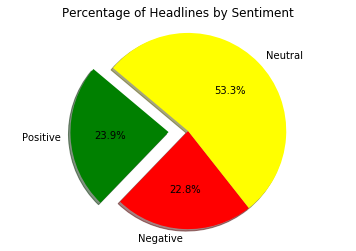

In [261]:
# Create a piechart
labels = 'Positive', 'Negative', 'Neutral'
sizes = [a, b, c]
colors = ['green', 'red', 'yellow']
explode = (0.2, 0, 0)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Headlines by Sentiment')
plt.show()

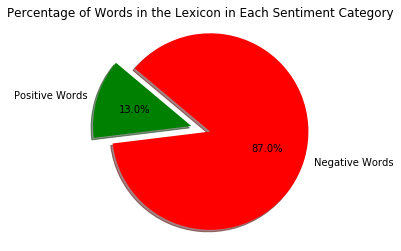

In [260]:
# Create a piechart
pos = len(pos_lex_list)/(len(neg_lex_list)+len(pos_lex_list))
neg = len(neg_lex_list)/(len(neg_lex_list)+len(pos_lex_list))
labels = 'Positive Words', 'Negative Words'
sizes = [pos, neg]
colors = ['green', 'red']
explode = (0.2, 0,)
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Percentage of Words in the Lexicon in Each Sentiment Category')
plt.show()

## Sentiment Analysis With NGRAM

In this second sentiment analysis, NGRAMs are identified and added to the lexicon. With the ngrams it will be posible to identify and to correct for the negation of sentiment words.
This requires a list of negation words. The script should iterate through the headline dataframe, find each instance of a negation word, check if it is followed by a sentiment word and if it is, then add the ngram to a list.
When the sentiment calculation is performed, the headline will be checked for each ngram to correct for negation.